#### Imports/preamble/helpers (nothing much to see here - feel free to skip)

In [1]:
from math import e, erf, pi, sqrt, exp
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from torch import Tensor

from unit_scaling.constraints import apply_constraint
from unit_scaling.scale import scale_fwd, scale_bwd

matplotlib.rc("axes", **{"spines.top": False, "spines.right": False})
matplotlib.rc("legend", frameon=False)

def jointplot(df: pd.DataFrame, *, x: str, y: str,
              xlabel: Optional[str] = None, ylabel: Optional[str] = None) -> sns.JointGrid:
    g = sns.JointGrid(data=df, x=x, y=y, height=4, ratio=2)
    g.plot_joint(sns.scatterplot, s=8, lw=0.2)
    g.plot_marginals(sns.histplot, bins=20)

    g.ax_joint.set_xticks([-2, -1, 0, 1, 2])
    g.ax_joint.set_xlim(-2.5, 2.5)
    g.ax_joint.set_xlabel(f"${xlabel or x}$")
    g.ax_joint.set_yticks([-2, -1, 0, 1, 2])
    g.ax_joint.set_ylim(-2.5, 2.5)
    g.ax_joint.set_ylabel(f"${ylabel or y}$")

    x_rms = sqrt((df[x]**2).mean())
    y_rms = sqrt((df[y]**2).mean())
    g.ax_marg_x.set_title(f"$\\mathrm{{RMS}}({xlabel or x})={x_rms:.2f}$", fontsize=10)
    g.ax_marg_y.set_title(f"$\\mathrm{{RMS}}({ylabel or y})={y_rms:.2f}$", fontsize=10)

def opplot(name_to_fn: Dict[str, Callable[[Tensor], Tensor]]) -> None:
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(9, 3))
    x = torch.linspace(-2.5, 2.5, int(1e4)).requires_grad_()
    for name, fn in name_to_fn.items():
        x.grad = None
        y = fn(x)
        y.backward(torch.ones_like(y))
        ax0.plot(x.detach(), y.detach(), label=f"y={name}")
        ax1.plot(x.detach(), x.grad)
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    ax1.set_xlabel("x")
    ax1.set_ylabel("dy/dx")
    fig.legend(*ax0.get_legend_handles_labels(), loc="center left", bbox_to_anchor=(.9, 0.5))

# How to unit-scale an op

[u-μP](https://arxiv.org/abs/2407.17465) mandates that the differentiable ops that make up a deep learning model should be properly _scaled_. A scaled op produces unit-std outputs when given unit-std inputs.

To achieve this, we insert scaling factors separately into the forward and backward passes, as follows:

```python
def hardtanh(x: Tensor, mult: float = 1) -> Tensor:
    y_scale, grad_scale = ...  # ???
    x = scale_bwd(x, grad_scale)
    y = F.hardtanh(x, -1/mult, 1/mult)
    return scale_fwd(y, y_scale)
```

This post is about how to choose `y_scale` and `grad_scale`, for the example of `hardtanh`, which looks like:

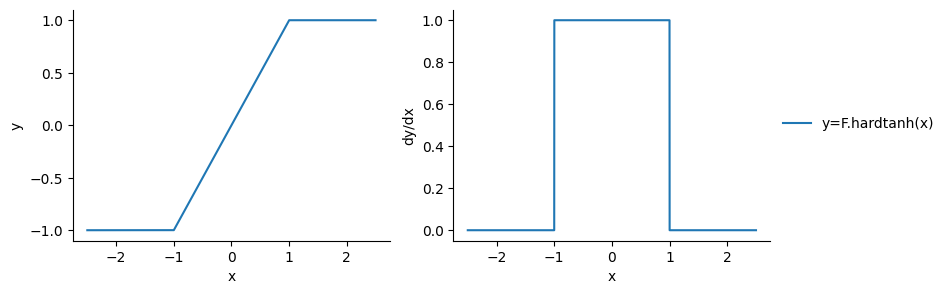

In [2]:
opplot({"F.hardtanh(x)": F.hardtanh})

## Empirical scaling

The simplest way to choose these factors is to feed inputs from an appropriate distribution (typically unit Gaussian), into both forward and backward passes, and measure how the scale changes. Then set scaling factors to counteract this.

Let's try:

In [3]:
def check_scaling(fn: Callable[[Tensor], Tensor], **kwargs: Any) -> None:
    x = torch.randn(int(1e6)).requires_grad_()
    y = fn(x, **kwargs)
    y.backward(torch.randn_like(y))

    name = f"{fn.__module__}.{fn.__name__}".replace("__main__.", "")
    print(name + (f" {kwargs}" if kwargs else ""))
    for k, v in {"x": x, "y": y, "grad_x": x.grad}.items():
        print(f"{k:>10}.std = {v.std(correction=0).item():.3f}")

check_scaling(F.hardtanh)

torch.nn.functional.hardtanh
         x.std = 1.000
         y.std = 0.718
    grad_x.std = 0.826


Now we can pluck these scales, and use them as `y_scale` and `grad_scale`:

In [4]:
def hardtanh_scaled_empirical(x: Tensor) -> Tensor:
    y_scale = 1 / 0.718
    grad_scale = 1 / 0.826
    x = scale_bwd(x, grad_scale)
    y = F.hardtanh(x)
    return scale_fwd(y, y_scale)

check_scaling(hardtanh_scaled_empirical)

hardtanh_scaled_empirical
         x.std = 1.000
         y.std = 1.001
    grad_x.std = 1.001


Success! We've unit-scaled hardtanh!

However, we still haven't dealt with `mult`, as these static factors do not generalise to different clipping thresholds. We could do this by fitting a curve `f` to `y.std = f(mult)`, but we'll instead use this as an opportunity to highlight an alternative approach based on statistical analysis.

## Statistical scaling

Our second approach will be to try to compute the output distribution and its' standard deviation, given an input distribution.

First, let's eyeball the forward-pass distribution for `y = hardtanh(x)` when $x \sim \mathcal{N}(0, 1)$. Note that this plot shows RMS, which is equal to standard deviation when zero-mean.

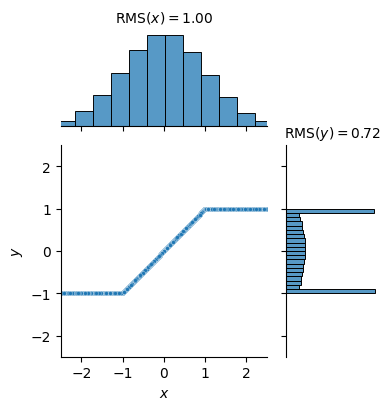

In [5]:
x = torch.randn(100000).requires_grad_()
y = F.hardtanh(x)
y.backward(torch.ones_like(y))
df = pd.DataFrame.from_dict(dict(x=x.detach(), y=y.detach(), grad_x=x.grad))

jointplot(df, x="x", y="y")

Since `hardtanh(x, mult)` is defined as `clip(x, -1/mult, 1/mult)`, we can see that the output distribution is a mixture of three components:

 - Truncated Gaussian with weight `p(-1/mult <= x <= 1/mult)`
 - Spike at `y=-1/mult` with weight `p(x < -1/mult)`
 - Spike at `y=1/mult` with weight `p(x > 1/mult)`

Therefore we know that $\mathrm{E(Y)=0}$ and can calculate the output scale, $\sqrt{\mathrm{E(Y^2)}}$, as a mixture of two distributions. Note that $\alpha = \mathrm{mult}$.

$Z = \mathrm{erf}(\frac{1}{\alpha\sqrt{2}})$

$\mathrm{E}(Y^2) = Z\,(1 - 2 e^{-1/(2\alpha^2)} / (Z \alpha \sqrt{2 \pi})) + (1-Z)\, \frac{1}{\alpha^2}$

Leading to the **forward scale**:

$\sqrt{\mathrm{E}(Y^2)} = \sqrt{\alpha^{-2} + (1 - \alpha^{-2})\,\mathrm{erf}(\frac{1}{\alpha\sqrt{2}}) - \sqrt{2/\pi}\, \alpha^{-1}\, e^{-\frac{1}{2}\alpha^{-2}}}$

> Note: when $\alpha\!=\!1$, this simplifies to $\sqrt{1 - \sqrt{2 / (\pi e)}}$

Let's test this rule by sweeping `mult` over a logarithmic range:

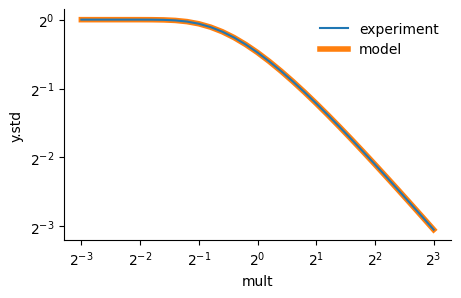

In [6]:
x = torch.randn(int(1e6)).requires_grad_()
mults = 2**torch.linspace(-3, 3, 31)
scales, grad_scales = [], []
for mult in mults:
    x.grad = None
    y = F.hardtanh(x, -1/mult, 1/mult)
    y.backward(torch.randn_like(y))
    scales.append(y.std(correction=0).item())
    grad_scales.append(x.grad.std(correction=0).item())

model_scales = [
    sqrt(mult**-2 + (1 - mult**-2) * erf(1/(mult*sqrt(2))) - sqrt(2/pi) * mult**-1 * exp(-1/2 * mult**-2))
    for mult in mults
]
_, ax = plt.subplots(figsize=(5, 3))
ax.plot(mults, scales, label="experiment", zorder=1)
ax.plot(mults, model_scales, lw=4, label="model", zorder=0)
ax.set_xscale("log", base=2); ax.set_yscale("log", base=2); ax.legend()
ax.set_xlabel("mult"); ax.set_ylabel("y.std");

This looks pretty solid.

Now for the backwards pass. Note that in this case we just feed in `y.grad = 1` in order to obtain the partial derivatives `dy/dx` that define the scaling behaviour:

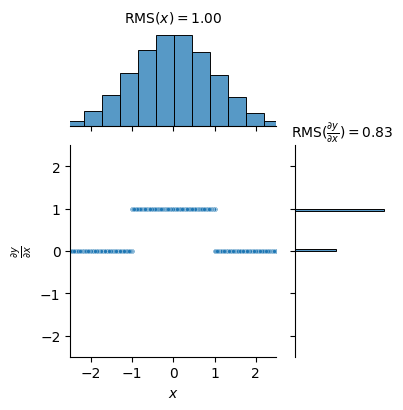

In [7]:
jointplot(df, x="x", y="grad_x", ylabel=r"\frac{\partial y}{\partial x}")

Now we note that the partial derivatives are a square pulse, where $\frac{\partial y}{\partial x}=1$ when $-1/\alpha <= x <= 1/\alpha$ and $0$ otherwise.

Therefore, we have the **backward scale**:

$\sqrt{\mathrm{E}(\dot{X}^2)} = \sqrt{Z} = \sqrt{\mathrm{erf}(\frac{1}{\alpha\sqrt{2}})}$

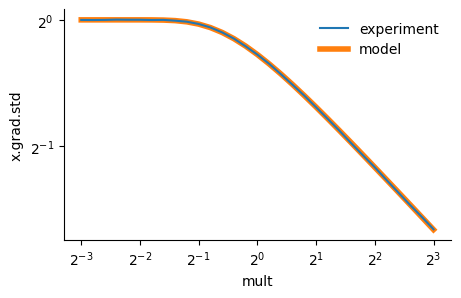

In [8]:
model_grad_scales = [sqrt(erf(1/(mult*sqrt(2)))) for mult in mults]

_, ax = plt.subplots(figsize=(5, 3))
ax.plot(mults, grad_scales, label="experiment", zorder=1)
ax.plot(mults, model_grad_scales, lw=4, label="model", zorder=0)
ax.set_xscale("log", base=2); ax.set_yscale("log", base=2); ax.legend()
ax.set_xlabel("mult"); ax.set_ylabel("x.grad.std");

Putting these rules together, we can test our new, 'fancy statistical' version of scaled hardtanh:

In [9]:
def hardtanh_scaled_statistical(x: Tensor, mult: float = 1.0) -> Tensor:
    Z = erf(1 / (mult * sqrt(2)))
    y_scale = 1 / sqrt(Z + (1 - Z) / mult**2 - sqrt(2/pi) / mult * exp(-1/2 / mult**2))
    grad_scale = 1 / sqrt(Z)
    x = scale_bwd(x, grad_scale)
    y = F.hardtanh(x, -1/mult, 1/mult)
    return scale_fwd(y, y_scale)

check_scaling(hardtanh_scaled_statistical); print()
check_scaling(hardtanh_scaled_statistical, mult=1/4); print()
check_scaling(hardtanh_scaled_statistical, mult=4)

hardtanh_scaled_statistical
         x.std = 1.000
         y.std = 1.000
    grad_x.std = 0.998

hardtanh_scaled_statistical {'mult': 0.25}
         x.std = 1.000
         y.std = 1.000
    grad_x.std = 1.000

hardtanh_scaled_statistical {'mult': 4}
         x.std = 0.999
         y.std = 1.000
    grad_x.std = 1.002


## Supporting scaling constraints

The version we've got is great for maintaining scale in the forward and backward passes. Unit scaling, however, sometimes requires these scales to be kept consistent. This is enforced by the user according to the cut edge rule (see the [unit scaling](https://arxiv.org/abs/2303.11257) paper for more detail) and supported in the op via a string argument `constraint`:

In [10]:
# (Final version)
def hardtanh(x: Tensor, constraint: Optional[str] = "to_output_scale", mult: float = 1) -> Tensor:
    Z = erf(1 / (mult * sqrt(2)))
    y_scale = 1 / sqrt(Z + (1 - Z) / mult**2 - sqrt(2/pi) / mult * exp(-1/2 / mult**2))
    grad_scale = 1 / sqrt(Z)
    y_scale, grad_scale = apply_constraint(constraint, y_scale, grad_scale)
    x = scale_bwd(x, grad_scale)
    y = F.hardtanh(x, -1/mult, 1/mult)
    return scale_fwd(y, y_scale)

check_scaling(hardtanh, constraint="to_output_scale"); print()
check_scaling(hardtanh, constraint="to_grad_input_scale"); print()
check_scaling(hardtanh, constraint="gmean"); print()
check_scaling(hardtanh, constraint=None); print()

hardtanh {'constraint': 'to_output_scale'}
         x.std = 1.000
         y.std = 1.000
    grad_x.std = 1.150

hardtanh {'constraint': 'to_grad_input_scale'}
         x.std = 1.000
         y.std = 0.869
    grad_x.std = 1.000

hardtanh {'constraint': 'gmean'}
         x.std = 1.000
         y.std = 0.932
    grad_x.std = 1.071

hardtanh {'constraint': None}
         x.std = 1.001
         y.std = 1.001
    grad_x.std = 1.002



Here we can see the tradeoff implied by constraints. When constraining the scaling factors, either the forward or backward passes can be well-scaled (or some tradeoff between them), but in general it isn't possible for both to have good scale when `y_scale == grad_scale`.

With larger `mult`, the constrained scaling rule must relax the unit scale requirement, as the ideal forward and backward scales are more different:

In [11]:
check_scaling(hardtanh, constraint="to_output_scale", mult=4); print()
check_scaling(hardtanh, constraint="to_grad_input_scale", mult=4)

hardtanh {'constraint': 'to_output_scale', 'mult': 4}
         x.std = 0.999
         y.std = 1.000
    grad_x.std = 1.904

hardtanh {'constraint': 'to_grad_input_scale', 'mult': 4}
         x.std = 1.000
         y.std = 0.524
    grad_x.std = 0.999


The default constraint should generally be `"to_output_scale"`, which keeps forward and backward passes consistent while prioritising forward-pass scaling. An exception is for arguments that are typically trainable parameters, where the default constraint should be `None`.

Let's take a look at the final scaled op (with default constraint):

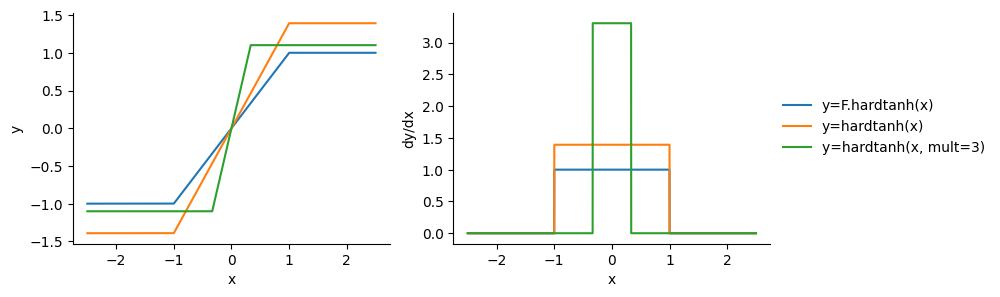

In [12]:
opplot({"F.hardtanh(x)": F.hardtanh,
        "hardtanh(x)": hardtanh,
        "hardtanh(x, mult=3)": lambda x: hardtanh(x, mult=3)})

## Summing up

That's it; scaling an op can be a relatively systematic process, based on either empirical or statistical analysis.

The main thing our `hardtanh` example missed is any dependence on input tensor shapes. Since it is an elementwise nonlinearity, these do not change the scaling behaviour. In general, a scaling rule would have to consider input shapes.

To unit-scale an op for u-μP:

 1. If needed, add a `mult` hyperparameter to control the shape of the op when the input scale is unit.
 1. Make distributional assumptions about the forward and backward pass inputs (typically: IID unit Gaussian).
 1. _Either:_ feed in data from these distributions and measure the change in `std`.
 1. _Or:_ do some maths to work out the theoretical change in `std`.
 1. Add the `apply_constraint` boilerplate to support constrained scales.
 1. Test it over a range of shapes and `mult` (if applicable), by feeding in artificial inputs & grad-outputs, measuring `std`.

To use the compendium of ops for which we have proposed scaling rules, or to develop your own rules, see https://github.com/graphcore-research/unit-scaling.

Thanks for reading!